<a href="https://colab.research.google.com/github/thibaudchevrier/maskrcnn-matterport-tf2/blob/main/notebooks/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

DATASET_PATH = "/content/drive/MyDrive/Final_project/datasets"

assert os.path.exists(DATASET_PATH), "Problem with registered path"
print("Path successfully verified !!!!")

Path successfully verified !!!!


In [ ]:
!pip install pillow

In [ ]:
import time
import numpy as np 
import tensorflow as tf
import json
import matplotlib.pyplot as plt 
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import required libraries
import os
import gc
import sys
import random
from pathlib import Path
import PIL
import io
import multiprocessing

import cv2 # CV2 for image manipulation
from tqdm import tqdm
from imgaug import augmenters as iaa
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold


# 1 - Train data import


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Final_project/datasets/imaterialist

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
label_descriptions.json  sample_submission.csv	test  train  train.csv


In [ ]:
with open('/content/drive/MyDrive/Final_project/datasets/imaterialist/label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
data = pd.read_csv("/content/drive/MyDrive/Final_project/datasets/imaterialist/train.csv") 
sample_sub_df = pd.read_csv('/content/drive/MyDrive/Final_project/datasets/imaterialist/sample_submission.csv')

In [ ]:
data.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


In [ ]:
data["AttributesIds"] = data["AttributesIds"].apply(lambda x: [int(element) for element in str(x).split(",")] if pd.notnull(x) else x)

In [ ]:
sample_sub_df.head()

,ImageId,EncodedPixels,ClassId,AttributesIds
0,003d41dd20f271d27219fe7ee6de727d,1 1,0,"111,137"
1,0046f98599f05fd7233973e430d6d04d,1 1,0,"111,137"
2,004e9e21cd1aca568a8ffc77a54638ce,1 1,0,"111,137"
3,005b37fce3c0f641d327d95dd832f51b,1 1,0,"111,137"
4,0094940c58c343b742f48ae26eb5e9fa,1 1,0,"111,137"


In [ ]:
sample_sub_df["AttributesIds"] = sample_sub_df["AttributesIds"].apply(lambda x: [int(element) for element in str(x).split(",")] if pd.notnull(x) else x)

In [ ]:
print(f'Shape of training dataset: {data.shape}')
print(f'Shape of testing dataset: {sample_sub_df.shape}')
print(f'# of images in training set: {data["ImageId"].nunique()}')
print(f'# of images in test set: {sample_sub_df["ImageId"].nunique()}')

Shape of training dataset: (333401, 6)
Shape of testing dataset: (3200, 4)
# of images in training set: 45623
# of images in test set: 3200


# 2 - Exploratory Data Analysis


## Image size analysis in training dataset

In [ ]:
pd.DataFrame([data['Height'].describe(), data['Width'].describe()]).T.loc[['max', 'min', 'mean']]

,Height,Width
max,8688.000000,10717.00000
min,296.000000,151.00000
mean,2235.524021,1761.97925


## Details about Classes and Attributes

In [ ]:
num_classes = len(label_desc['categories'])
num_attributes = len(label_desc['attributes'])
print(f'Total # of classes: {num_classes}')
print(f'Total # of attributes: {num_attributes}')

Total # of classes: 46
Total # of attributes: 294


In [ ]:
categories_df = pd.DataFrame(label_desc['categories'])
attributes_df = pd.DataFrame(label_desc['attributes'])
categories_df

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [ ]:
pd.set_option('display.max_rows', 300)
attributes_df

,id,name,supercategory,level
0,0,classic (t-shirt),nickname,1
1,1,polo (shirt),nickname,1
2,2,undershirt,nickname,1
3,3,henley (shirt),nickname,1
4,4,ringer (t-shirt),nickname,1
5,5,raglan (t-shirt),nickname,1
6,6,rugby (shirt),nickname,1
7,7,sailor (shirt),nickname,1
8,8,crop (top),nickname,1
9,9,halter (top),nickname,1


On crée un dataset  "image_df" qui contient des id  uniques des images:

In [ ]:
image_df = data.groupby('ImageId')['AttributesIds', 'ClassId'].agg(lambda x: list(x))
image_df.reset_index(inplace=True)
image_df['ImageId'] = image_df['ImageId'].astype('str')
image_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,ImageId,AttributesIds,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e,"[[115, 136, 143, 154, 230, 295, 316, 317], [11...","[6, 0, 28, 31, 32, 32, 31, 29, 4]"
1,0000fe7c9191fba733c8a69cfaf962b7,"[[190], [0, 115, 145, 146, 295, 316, 317]]","[33, 1]"
2,0002ec21ddb8477e98b2cbb87ea2e269,"[[182], [102, 128, 142, 150, 229, 295, 301, 31...","[33, 10, 23, 23]"
3,0002f5a0ebc162ecfb73e2c91e3b8f62,"[[108, 115, 119, 141, 155, 229, 286, 316, 317]...","[10, 33, 15]"
4,0004467156e47b0eb6de4aa6479cbd15,"[[115, 141, 155, 295, 305, 317], [188], [159],...","[10, 33, 31, 31, 15]"


In [ ]:
categorie_names = {cat["id"]: cat["name"] for cat in label_desc['categories']}
attribute_names = {cat["id"]: cat["name"] for cat in label_desc['attributes']}

Affiche valeurs uniques des IDclasses par Image:

In [ ]:
import itertools

image_df['SetClassId'] = image_df["ClassId"].apply(lambda x: set(x))
image_df['SetAttributesIds'] = image_df["AttributesIds"].apply(lambda x: [set(element) if type(element) is list else element for element in x ])
image_df.drop(['AttributesIds','ClassId'],axis=1,inplace=True)


## Plotting a few training images without any masks

**************************************************


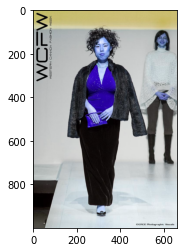

[0] neckline
[1] top, t-shirt, sweatshirt: [0] wrist-length, [1] set-in sleeve
[2] jacket: [0] wrist-length, [1] set-in sleeve
[3] skirt
[4] shoe: [0] v-neck
[5] bag, wallet: [0] fur, [1] regular (fit), [2] no waistline, [3] above-the-hip (length), [4] symmetrical, [5] lining
[6] sleeve: [0] zip-up, [1] no non-textile material, [2] low waist, [3] symmetrical, [4] floor (length), [5] no special manufacturing technique, [6] plain (pattern), [7] pencil
**********
**************************************************


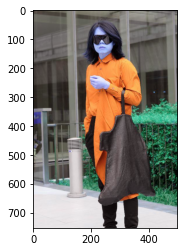

[0] shirt, blouse
[1] pants
[2] glasses: [0] no special manufacturing technique, [1] normal waist, [2] no non-textile material
[3] bag, wallet: [0] single breasted, [1] no non-textile material, [2] regular (fit), [3] no waistline, [4] above-the-hip (length), [5] symmetrical, [6] no special manufacturing technique, [7] plain (pattern)
[4] collar: [0] wrist-length
[5] sleeve: [0] wrist-length, [1] set-in sleeve
**********
**************************************************


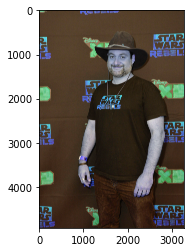

[0] neckline: [0] jeans, [1] fly (opening), [2] no non-textile material, [3] regular (fit), [4] washed, [5] plain (pattern)
[1] top, t-shirt, sweatshirt: [0] set-in sleeve, [1] short (length)
[2] pants: [0] short (length)
[3] hat: [0] round (neck)
[4] sleeve: [0] classic (t-shirt), [1] letters, numbers, [2] tight (fit), [3] no non-textile material, [4] printed, [5] no waistline, [6] above-the-hip (length), [7] symmetrical, [8] plain (pattern)
**********
**************************************************


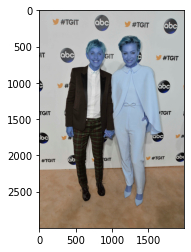

[0] pocket
[1] shirt, blouse
[2] jacket: [0] check, [1] no non-textile material, [2] regular (fit), [3] printed, [4] low waist, [5] maxi (length)
[3] pants: [0] single breasted, [1] blazer, [2] symmetrical, [3] hip (length), [4] plastic, [5] no special manufacturing technique, [6] plain (pattern)
[4] watch: [0] wrist-length, [1] set-in sleeve
[5] shoe: [0] wrist-length
[6] collar: [0] peak (lapel)
[7] lapel: [0] welt (pocket)
[8] sleeve: [0] flap (pocket)
**********
**************************************************


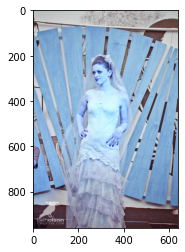

[0] neckline: [0] a-line, [1] zip-up, [2] floral, [3] no non-textile material, [4] gown, [5] normal waist, [6] symmetrical, [7] tiered
[1] dress
[2] ruffle
[3] headband, head covering, hair accessory: [0] sweetheart (neckline)
**********


In [ ]:
for i in range(5):
    x = np.random.randint(0,len(image_df),size=(1,))[0]
    ID = image_df['ImageId'].iloc[x]
    classes = image_df['SetClassId'].iloc[x]
    attributes = image_df['SetAttributesIds'].iloc[x]
    print('*'*50)
    plt.imshow(cv2.imread(f'/content/drive/MyDrive/Final_project/datasets/imaterialist/train/{ID}.jpg'))
    plt.show()
    for j, idx in enumerate(classes):
        attribute_display = ""
        if pd.notnull(attributes[j]):
            attribute_display = ": " + ", ".join(['[{}] {}'.format(j_attr, attribute_names[idx_attr]) for j_attr, idx_attr in enumerate(attributes[j])])
        categorie_display = '[{}] {}'.format(j,categorie_names[idx])
        print(categorie_display + attribute_display)
    print('*'*10)

## Plotting a few images with given segments

In [ ]:
def create_mask(size):
    image_ids = image_df['ImageId'][:size]
    images_meta=[]

    for image_id in image_ids:
        img = mpimg.imread(f'/content/drive/MyDrive/Final_project/datasets/imaterialist/train/{image_id}.jpg')
        images_meta.append({
            'image': img,
            'shape': img.shape,
            'encoded_pixels': data[data['ImageId'] == image_id]['EncodedPixels'],
            'class_ids':  data[data['ImageId'] == image_id]['ClassId']
        })

    masks = []
    for image in images_meta:
        shape = image.get('shape')
        encoded_pixels = list(image.get('encoded_pixels'))
        class_ids = list(image.get('class_ids'))
        
        # Initialize numpy array with shape same as image size
        height, width = shape[:2]
        mask = np.zeros((height, width)).reshape(-1)
        
        # Iterate over encoded pixels and create mask
        #Création d'un mask à partir de pixels encodés:
        for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()))
            pixel_starts = splitted_pixels[::2]
            run_lengths = splitted_pixels[1::2]
            assert max(pixel_starts) < mask.shape[0]
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                pixel_start = int(pixel_start) - 1
                run_length = int(run_length)
                mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4
        masks.append(mask.reshape((height, width), order='F'))  # https://stackoverflow.com/questions/45973722/how-does-numpy-reshape-with-order-f-work
    return masks, images_meta

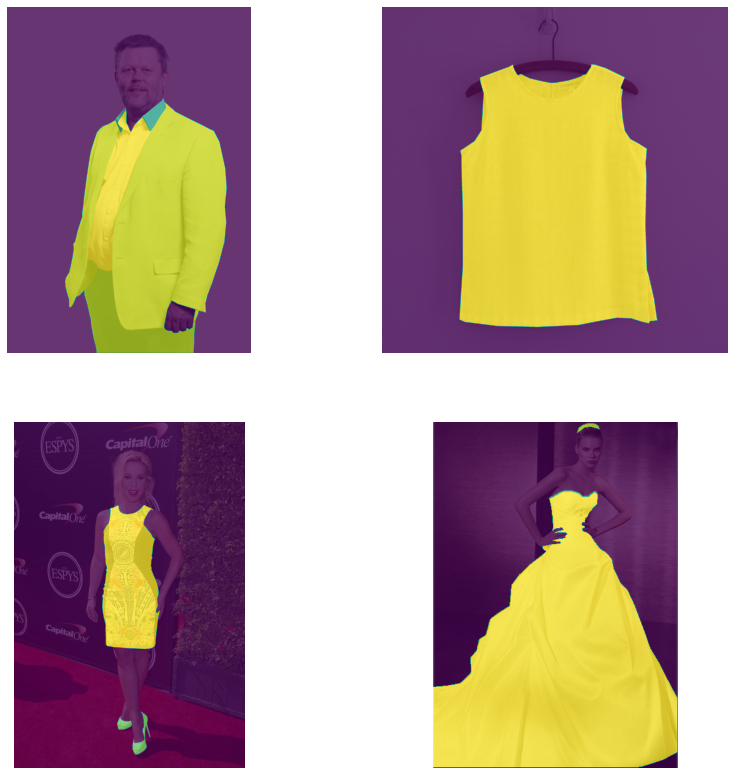

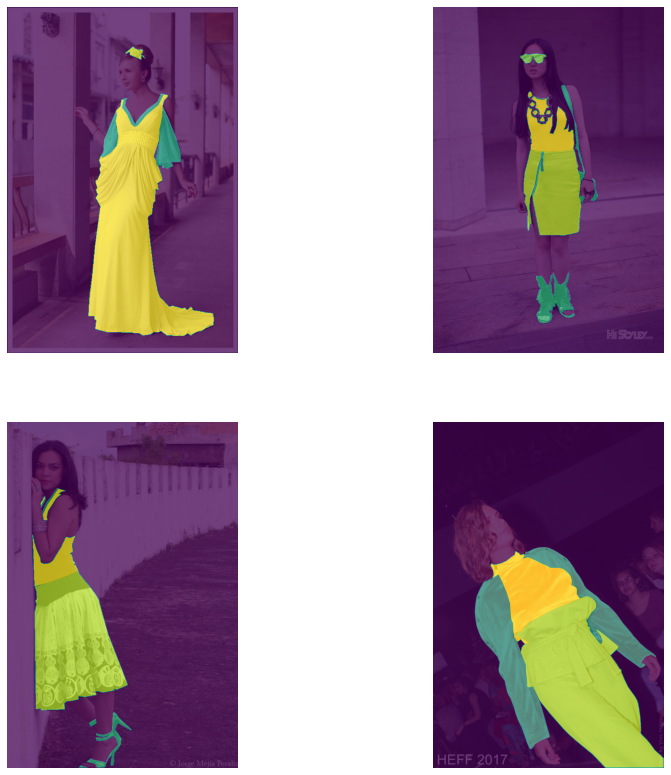

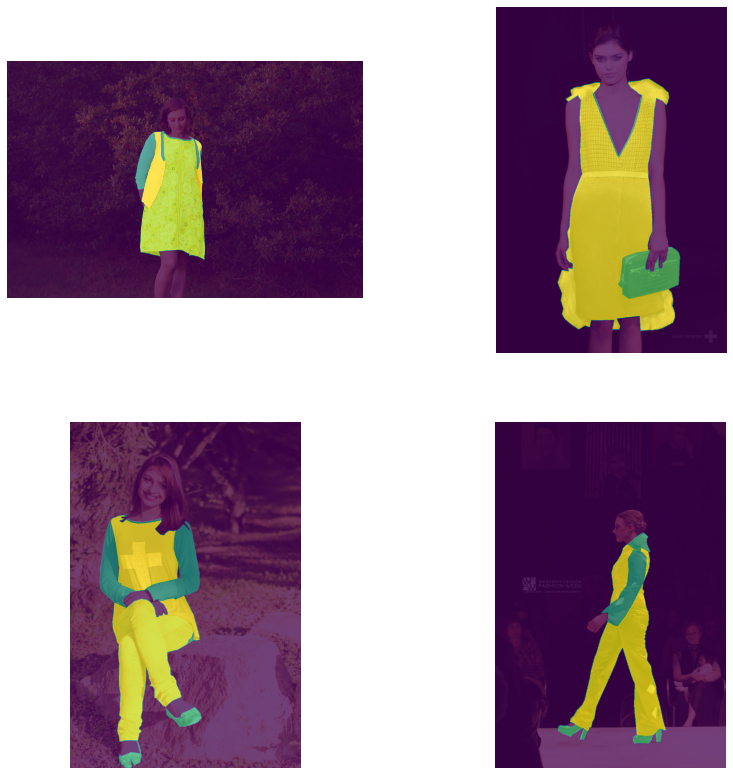

In [ ]:
def plot_segmented_images(size=12, figsize=(14, 14)):
    # First create masks from given segments
    masks, images_meta = create_mask(size)
    
    # Plot images in groups of 4 images
    n_groups = 4
    
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images_meta[count]['image'])
                col.imshow(masks[count], alpha=0.75)
                col.axis('off')
                count += 1
        plt.show()


plot_segmented_images()

## Analysing Categories and Attributes

In [ ]:
categories_df = pd.DataFrame(label_desc['categories'])
attributes_df = pd.DataFrame(label_desc['attributes'])
categories_df

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [ ]:
category_map, attribute_map = {}, {}
for cat in label_desc.get('categories'):
    category_map[cat.get('id')] = cat.get('name')
for attr in label_desc.get('attributes'):
    attribute_map[attr.get('id')] = attr.get('name')

In [ ]:
data['ClassId'] = data['ClassId'].map(category_map)
data['ClassId'] = data['ClassId'].astype('category')

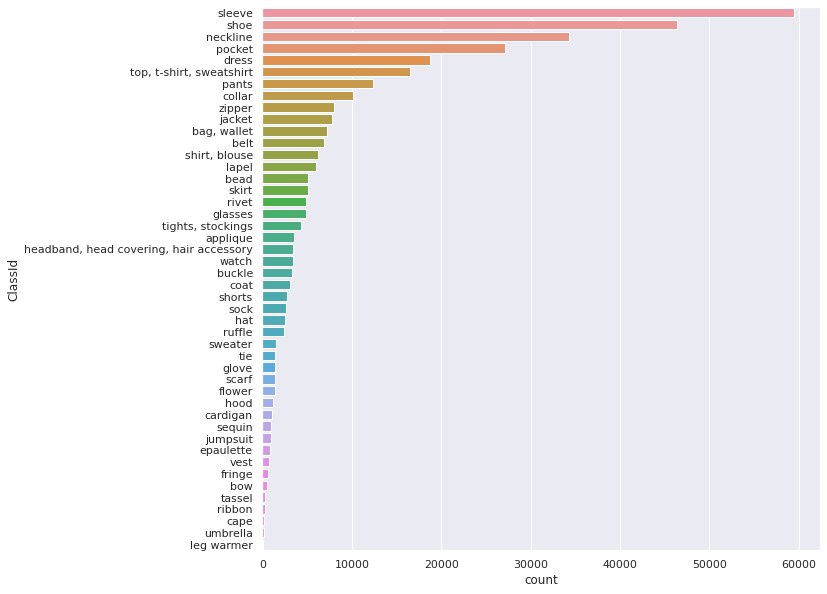

In [ ]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (10,10))
sns.countplot(y='ClassId',data=data , ax=ax, order = data['ClassId'].value_counts().index)
fig.show()

In [ ]:
IMAGE_ID = '000b3ec2c6eaffb491a5abb72c2e3e26'

This image has 8 segmentes and a few attributes:

In [ ]:
# Get the an image id given in the training set for visualization
vis_df = data[data['ImageId'] == IMAGE_ID]
vis_df['ClassId'] = vis_df['ClassId'].cat.codes
vis_df = vis_df.reset_index(drop=True)
vis_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,000b3ec2c6eaffb491a5abb72c2e3e26,752989 6 755294 19 757599 31 759904 44 762209 ...,2310,1536,32,NaN
1,000b3ec2c6eaffb491a5abb72c2e3e26,1468756 2 1471067 9 1473378 15 1475689 21 1478...,2310,1536,32,NaN
2,000b3ec2c6eaffb491a5abb72c2e3e26,701292 5 703597 15 705903 25 708209 34 710515 ...,2310,1536,24,"[115, 135, 154, 230, 295, 316, 317]"
3,000b3ec2c6eaffb491a5abb72c2e3e26,458445 17 460731 51 463017 85 465303 115 46759...,2310,1536,41,"[0, 115, 136, 145, 147, 295, 314, 317]"
4,000b3ec2c6eaffb491a5abb72c2e3e26,1787118 1 1789427 1 1791735 3 1794044 3 179635...,2310,1536,25,[218]
5,000b3ec2c6eaffb491a5abb72c2e3e26,1139954 1 1142264 1 1144573 2 1146882 3 114919...,2310,1536,35,"[160, 204]"
6,000b3ec2c6eaffb491a5abb72c2e3e26,458445 17 460731 51 463017 85 465303 115 46759...,2310,1536,35,"[160, 204]"
7,000b3ec2c6eaffb491a5abb72c2e3e26,839153 2 841462 6 843771 10 846081 12 848390 1...,2310,1536,23,[190]



### Plot each segment in a separate image

In [ ]:
segments = list(vis_df['EncodedPixels'])
class_ids = list(vis_df['ClassId'])
masks = []
for segment, class_id in zip(segments, class_ids):
    
    height = vis_df['Height'][0]
    width = vis_df['Width'][0]
    # Initialize empty mask
    mask = np.zeros((height, width)).reshape(-1)
    
    # Iterate over encoded pixels and create mask
    splitted_pixels = list(map(int, segment.split()))
    pixel_starts = splitted_pixels[::2]
    run_lengths = splitted_pixels[1::2]
    assert max(pixel_starts) < mask.shape[0]
    for pixel_start, run_length in zip(pixel_starts, run_lengths):
        pixel_start = int(pixel_start) - 1
        run_length = int(run_length)
        mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4

    mask = mask.reshape((height, width), order='F')
    masks.append(mask)

[]

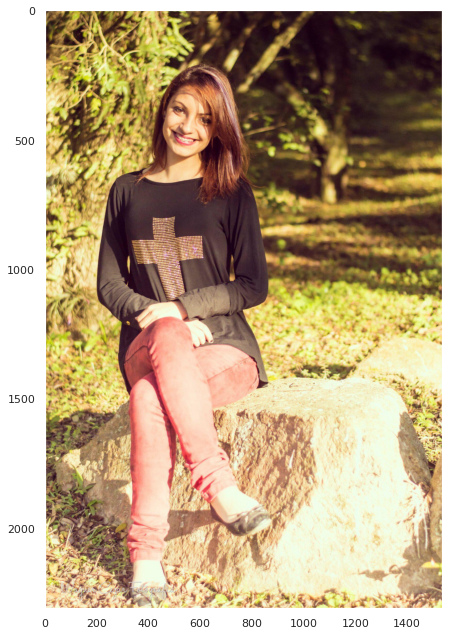

In [ ]:
plt.figure(figsize = (110,11))
image = mpimg.imread(f'/content/drive/MyDrive/Final_project/datasets/imaterialist/train/{IMAGE_ID}.jpg')
plt.grid(False)
plt.imshow(image)
plt.plot()

In [ ]:
def plot_individual_segment(*masks, image, figsize=(110, 11)):
    plt.figure(figsize = figsize)
    plt.imshow(image)
    for mask in masks:
        plt.imshow(mask, alpha=0.6)

    plt.axis('off')
    plt.show()

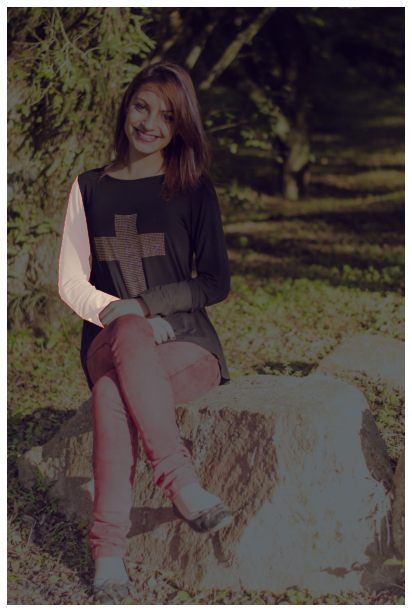

Category:  zipper
Attributes:  wrist-length, set-in sleeve


In [ ]:
index=6 #change index  to visualize the segment

plot_individual_segment(masks[index], image=image)
print("Category: ", categories_df["name"][vis_df["ClassId"][index]])
attributes = vis_df["AttributesIds"][index]
if type(attributes) is list:
    print("Attributes: ", ", ".join([attributes_df["name"][idx] for idx in attributes]))

Some of the segments have no attributes. Let's check how many such segment exists in training dataset.

In [ ]:
print(f'Segments that do not have attributes: {data["AttributesIds"].isna().sum()/len(data) * 100} %')

Segments that do not have attributes: 38.089567817733 %


Missing values of dataset:

In [ ]:
data[['ImageId', 'EncodedPixels', 'Height', 'Width', 'ClassId']].isna().sum()

ImageId          0
EncodedPixels    0
Height           0
Width            0
ClassId          0
dtype: int64

#3 - Data preprocessing

Drop attributeIds for simplicity for now. ! DO NOT FORGET TO ADD THEM FOR MORE COMPLEXE MODEL ! 

In [ ]:
with open('/content/drive/MyDrive/Final_project/datasets/imaterialist/label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
data = pd.read_csv("/content/drive/MyDrive/Final_project/datasets/imaterialist/train.csv") 
sample_sub_df = pd.read_csv('/content/drive/MyDrive/Final_project/datasets/imaterialist/sample_submission.csv')

data['ClassId'] = data['ClassId'].astype('category')
data = data.drop('AttributesIds', axis=1)


image_df = data.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x))
size_df = data.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


Total images:  45623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


,EncodedPixels,ClassId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [ ]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 8

# Split en 90-10% environ ( 5691/(39933+5691))
kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

len_train, _ = train_df.shape
len_val, _ = valid_df.shape

In [ ]:
TRAIN_IMAGE_DIR = "/content/drive/MyDrive/Final_project/datasets/imaterialist/train"

def read_image(filename):
    full_path = os.path.join(TRAIN_IMAGE_DIR, filename + ".jpg")
    with tf.io.gfile.GFile(full_path, 'rb') as fid:
      encoded_jpg = fid.read()
    image = PIL.Image.open(io.BytesIO(encoded_jpg))
    return full_path, encoded_jpg, image

def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    horizontal_indicies = np.where(np.any(mask, axis=0))[0]
    vertical_indicies = np.where(np.any(mask, axis=1))[0]
    if horizontal_indicies.shape[0]:
        x1, x2 = horizontal_indicies[[0, -1]]
        y1, y2 = vertical_indicies[[0, -1]]
        # x2 and y2 should not be part of the box. Increment by 1.
        x2 += 1
        y2 += 1
    else:
        # No mask for this instance. Might happen due to
        # resizing or cropping. Set bbox to zeros
        x1, x2, y1, y2 = 0, 0, 0, 0
    return [float(x1), float(x2), float(y1), float(y2)]

def binary_mask(segments, height, width):
    """Converts RLE to a binary mask."""
    encoded_mask_png, area, xmin, xmax, ymin, ymax = [], [], [], [], [], []
    for segment in segments:
        encoded_pixels = list(map(int, segment.split()))
        mask = np.zeros(height * width, dtype=np.uint8)
        for start_pixel, num_pixels in zip(encoded_pixels[::2], encoded_pixels[1::2]):
            start_pixel -= 1
            mask[start_pixel:start_pixel + num_pixels] = 1

        binary_mask = mask.reshape((height, width), order='F')
        cord = extract_bboxes(binary_mask)
        xmin.append(cord[0])
        xmax.append(cord[1])
        ymin.append(cord[2])
        ymax.append(cord[3])
        contours, hierarchy = cv2.findContours(
            binary_mask*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
        area.append(cv2.contourArea(contours[0]))

        pil_image = PIL.Image.fromarray(binary_mask)
        output_io = io.BytesIO()
        pil_image.save(output_io, format='PNG')
        encoded_mask_png.append(output_io.getvalue())

    return encoded_mask_png, area, xmin, xmax, ymin, ymax

def file_path(output_path, index, len_df):
    return output_path + '-%05d-of-%05d.tfrecord' % (index, len_df)

In [ ]:
import hashlib

categorie_names = {cat["id"]: cat["name"] for cat in label_desc['categories']}

def create_tf_example(source_id, row):
    full_path, encoded_jpg, image = read_image(str(source_id).strip())
    encoded_mask_png, area, xmin, xmax, ymin, ymax = binary_mask(row['EncodedPixels'], image.height, image.width)
    feature_dict = {
      'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[image.width])),
      'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[image.height])),
      'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[full_path.encode('utf8')])),
      'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[hashlib.sha256(encoded_jpg).hexdigest().encode('utf8')])),
      'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_jpg])),
      'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
      'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[str(source_id).strip().encode('utf8')])),
      'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
      'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
      'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
      'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
      'image/object/is_crowd': tf.train.Feature(int64_list=tf.train.Int64List(value=[0] * len(xmin))),
      'image/object/area': tf.train.Feature(float_list=tf.train.FloatList(value=area)),
      'image/object/class/text': tf.train.Feature(int64_list=tf.train.BytesList(value=[categorie_names[id].encode('utf8') for id in row['ClassId']])),
      'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=row['ClassId'])),
      'image/object/mask' : tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_mask_png))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature_dict))

In [ ]:
categorie_names = {cat["id"]: cat["name"] for cat in label_desc['categories']}
categorie_names[0]

'shirt, blouse'

In [ ]:
def data_to_tfrecords(df, output_path):
  len_df, _ = df.shape
  for idx, (source_id, row) in enumerate(df.iterrows()):
      return create_tf_example(source_id, row)

def create_tf_records(df, output_path):
    len_df, _ = df.shape
    writers = [
        tf.io.TFRecordWriter(file_path(output_path, i, len_df))
        for i in range(len_df)]
    len(writers)
    pool = multiprocessing.Pool()
    for idx, tf_example in enumerate(pool.imap(
        create_tf_example, [element for index, element in enumerate(df.iterrows())])
    ):
        writers[idx % len_df].write(tf_example.SerializeToString())

    pool.close()
    pool.join()

    for writer in writers:
        writer.close()

In [ ]:
import glob
TRAIN_TFRECORD_PATH = './temp/train'
VAL_TFRECORD_PATH = './temp/val'

!rm -rf ./temp/*
assert len(glob.glob(TRAIN_TFRECORD_PATH + "-*")) == 0
assert len(glob.glob(VAL_TFRECORD_PATH + "-*")) == 0

try:
  create_tf_records(train_df, TRAIN_TFRECORD_PATH)
except:
  print("Training tfrecords done with %d files!" % len(glob.glob(TRAIN_TFRECORD_PATH + "-*")))
try:
  create_tf_records(valid_df, VAL_TFRECORD_PATH)
except:
  print("Training tfrecords done with %d files!" % len(glob.glob(VAL_TFRECORD_PATH + "-*")))

Training tfrecords done with 39920 files!
Training tfrecords done with 5703 files!


In [ ]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'PROJECT_ID'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
!gsutil mb -p $'PROJECT_ID' -c standard -l europe-west4 -b on gs://immaterialist

Creating gs://immaterialist/...


In [ ]:
!gsutil -m cp ./temp/* gs://immaterialist/coco

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Copying file://./temp/val-00705-of-05703.tfrecord [Content-Type=application/octet-stream]...
Copying file://./temp/val-00706-of-05703.tfrecord [Content-Type=application/octet-stream]...
Copying file://./temp/val-00707-of-05703.tfrecord [Content-Type=application/octet-stream]...
Copying file://./temp/val-00708-of-05703.tfrecord [Content-Type=application/octet-stream]...
Copying file://./temp/val-00709-of-05703.tfrecord [Content-Type=application/octet-stream]...
Copying file://./temp/val-00710-of-05703.tfrecord [Content-Type=application/octet-stream]...
Copying file://./temp/val-00711-of-05703.tfrecord [Content-Type=application/octet-stream]...
Copying file://./temp/val-00712-of-05703.tfrecord [Content-Type=application/octet-stream]...
Copying file://./temp/val-00713-of-05703.tfrecord [Content-Type=application/octet-stream]...
Copying file://./temp/val-00714-of-05703.tfrecord [Content-Type=application/octet-str